In [129]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import scikit_posthocs as sp
import pingouin as pg

In [192]:
LEVELS = ['easy', 'moderate', 'hard']
scores_melted = {}
scores_wide = {}
for lvl in LEVELS:
    results = pd.read_csv(os.path.join(f"discrete_env_results_{lvl}", f"scores_{lvl}_env.csv"))
    results_no_before = results.drop(columns=[c for c in results.columns if 'before' in c])
    results_melted = results_no_before.melt(var_name='model')
    results_melted['setup'] = lvl
    scores_melted[lvl] = results_melted
    scores_wide[lvl] = results_no_before

all_scores_melted = pd.concat(scores_melted.values(), ignore_index=True)
all_scores_melted.model = all_scores_melted.model.str.replace("baseline", "optimizer")

In [193]:
scores_wide['hard'].describe().round(3).loc[['mean', '50%', 'std']] [['random', 'baseline', 'VPG after', 'AC after', 'PPO after']]

,random,baseline,VPG after,AC after,PPO after
mean,-268.207,-115.573,-73.364,137.743,529.445
50%,-171.000,-113.268,-72.109,-107.305,532.573
std,185.856,12.073,9.932,531.494,134.387


In [194]:
sns.set_theme(style="whitegrid")

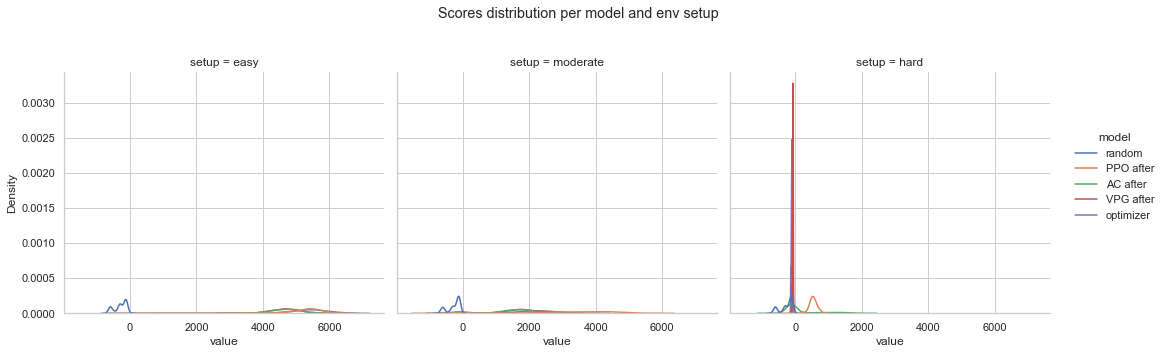

In [195]:
displot = sns.displot(data=all_scores_melted, col='setup', hue='model', x='value', kind='kde')
displot.fig.subplots_adjust(top=0.8)
displot.fig.suptitle("Scores distribution per model and env setup");

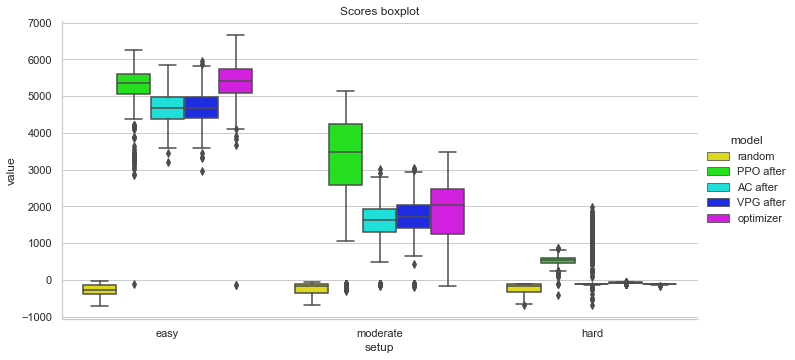

In [197]:
boxplot = sns.catplot(data=all_scores_melted, x='setup', y='value', hue='model', kind='box', aspect=2, palette='hsv')
boxplot.set(title="Scores boxplot");
plt.savefig("scores_comparison.svg")

In [159]:
#g = sns.FacaetGrid(all_scores, col='model', hue='value')
#g.map(sns.kdeplot, 'setup')

In [82]:
from scipy.stats import bootstrap

In [106]:
def bootstrap_ci(df, variable, classes, repetitions = 1000, alpha = 0.05, random_state=None):
    # df: a data frame that includes observations of the two sample
    # variable: the column name of the column that includes observations
    # classes: the column name of the column that includes group assignment (This column should contain two different group names)
    # repetitions: number of times you want the bootstrapping to repeat. Default is 1000.
    # alpha: likelihood that the true population parameter lies outside the confidence interval. Default is 0.05.
    # random_stata: enable users to set their own random_state, default is None.

    df = df[[variable, classes]]
    bootstrap_sample_size = len(df)

    mean_diffs = []

    for i in range(repetitions):
        bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
        mean_diff = bootstrap_sample.groupby(classes).mean().iloc[1,0] - bootstrap_sample.groupby(classes).mean().iloc[0,0]
        mean_diffs.append(mean_diff)

    # confidence interval
    left = np.percentile(mean_diffs, alpha/2*100)
    right = np.percentile(mean_diffs, 100-alpha/2*100)

    # point estimate
    point_est = df.groupby(classes).mean().iloc[1,0] - df.groupby(classes).mean().iloc[0,0]

    print('Point estimate of difference between means:', round(point_est,2))
    print('Mean diffs summary', bootstrap_sample.groupby(classes).mean())
    print((1-alpha)*100,'%','confidence interval for the difference between means:', (round(left,2), round(right,2)))

In [112]:
bootstrap_ci(
    all_scores_melted.loc[(all_scores_melted.setup == 'hard') & (all_scores_melted.model.isin(['PPO after', 'baseline']))], 'value', 'model', alpha=0.01)

Point estimate of difference between means: -18.46
Mean diffs summary                 value
model                
PPO after -101.066098
baseline  -120.348513
99.0 % confidence interval for the difference between means: (-23.45, -11.51)


In [189]:
pg.welch_anova(all_scores_melted[all_scores_melted.setup == 'hard'], dv='value', between='model').round(5)

,Source,ddof1,ddof2,F,p-unc,np2
0,model,4,1136.25873,3694.87157,0.0,0.53246


In [185]:
pairwise_test_res = pg.pairwise_gameshowell(
    all_scores_melted[all_scores_melted.setup == 'moderate'],
    dv='value',
    between='model')
pairwise_test_res.rename(columns={"hedges": "Eff. size", "pval": "P-val", 'T': "Statistic", "diff": "Score diff", "se": "Diff se"})
pairwise_test_res.round(2)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,AC after,PPO after,1524.03,3145.00,-1620.97,70.46,-23.01,708.13,0.00,-1.45
1,AC after,VPG after,1524.03,1649.71,-125.68,41.81,-3.01,997.48,0.02,-0.19
2,AC after,baseline,1524.03,1696.87,-172.84,56.87,-3.04,831.77,0.02,-0.19
3,AC after,random,1524.03,-266.28,1790.31,31.05,57.65,577.04,0.00,3.64
4,PPO after,VPG after,3145.00,1649.71,1495.29,70.17,21.31,699.61,0.00,1.35
5,PPO after,baseline,3145.00,1696.87,1448.14,80.06,18.09,930.19,0.00,1.14
6,PPO after,random,3145.00,-266.28,3411.28,64.35,53.01,516.24,0.00,3.35
7,VPG after,baseline,1649.71,1696.87,-47.16,56.51,-0.83,820.52,0.90,-0.05
8,VPG after,random,1649.71,-266.28,1915.99,30.41,63.01,580.64,0.00,3.98
9,baseline,random,1696.87,-266.28,1963.14,49.09,39.99,528.98,0.00,2.53


In [173]:
pairwise_test_res.loc[
    (pairwise_test_res.A == "AC after") &
    (pairwise_test_res.B == "random")].round(2)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
3,AC after,random,4685.79,-290.89,4976.68,20.67,240.73,674.74,0.0,15.21
